### Microsoft GraphRAG
The codes are mainly from: https://github.com/stephenc222/example-graphrag

#### Install the pacakges

In [1]:
# %%capture --no-stderr
# %pip install openai networkx cdlib leidenalg python-igraph

In [2]:
import os
from typing import List
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from cdlib import algorithms
from tqdm import tqdm

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'wurlitzer', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [3]:
# Init OpenAI Client
OPENAI_API_KEY = "xxx"
client = OpenAI(api_key=OPENAI_API_KEY)

#### Download the txt documents from Google Drive

In [4]:
import requests

def download_file_from_google_drive(file_id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': file_id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)
    print(f"Downloaded {destination} successfully!")

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

doc_id_1 = '1LCWfGre6LusSSZAd2vvcWIHwGVmG3mwa'
doc_id_2 = '1xK_vdN_nmKUYwQKz6X4auRR_CGAXkhuN'
doc_id_3 = '1m0U4pbnAg_kpYAO4thIbpVUV5bg9Qw0_'
download_file_from_google_drive(doc_id_1, "doc1.txt")
download_file_from_google_drive(doc_id_2, "doc2.txt")
download_file_from_google_drive(doc_id_3, "doc3.txt")

Downloaded doc1.txt successfully!
Downloaded doc2.txt successfully!
Downloaded doc3.txt successfully!


In [5]:
# Load the documents
def load_documents(folder_path: str) -> List[str]:
    documents = []
    for filename in tqdm(os.listdir(folder_path), desc="Loading documents"):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), "r") as file:
                documents.append(file.read())
    return documents


documents = load_documents(folder_path=".")

Loading documents: 100%|██████████| 7/7 [00:00<00:00, 4847.31it/s]


#### 1. Source Documents -> Text Chunks

chunks[0]:

Document 3: Environmental Policies and Their Effectiveness\n\nEnvironmental policies are essential tools for protecting natural ecosystems, promoting sustainability, and addressing environmental challenges such as pollution, deforestation, and climate change. These policies, implemented by governments, international organizations, and local authorities, set regulations and guidelines to manage human activities and reduce their negative impacts on the environment. The effectiveness of environmental policies depends on their design, implementation, enforcement, and the cooperation of various s
```


In [6]:
# 1. Source Documents -> Text Chunks
def split_documents_into_chunks(
    documents: List[str], chunk_size: int = 600, overlap_size: int = 100
):
    chunks = []
    for doc in tqdm(documents, desc="1. Source Documents -> Text Chunks"):
        for i in range(0, len(doc), chunk_size - overlap_size):
            chunks.append(doc[i : i + chunk_size])
    return chunks

#### 2. Text Chunks -> Element Instances

instances[0]:

Entities:\n
1. Environmental policies\n
2. Natural ecosystems\n
3. Sustainability\n
4. Environmental challenges\n
5. Pollution\n
6. Deforestation\n
7. Climate change\n
8. Governments\n
9. International organizations\n
10. Local authorities\n
11. Regulations\n
12. Guidelines\n
13. Human activities\n
14. Environment\n\n

Relationships:\n
1. Environmental policies are essential tools for protecting natural ecosystems.\n
2. Environmental policies promote sustainability.\n
3. Environmental policies address environmental challenges such as pollution, deforestation, and climate change.\n
4. Environmental policies are implemented by governments, international organizations, and local authorities.\n
5. Environmental policies set regulations and guidelines to manage human activities.\n
6. Regulations and guidelines reduce the negative impacts of human activities on the environment.\n
7. The effectiveness of environmental policies depends on design, implementation, enforcement, and cooperation of various stakeholders.


In [7]:
# 2. Text Chunks -> Element Instances
def extract_instances_from_chunks(chunks: List[str]):
    instances = []
    for chunk in tqdm(chunks, desc="2. Text Chunks -> Element Instances"):
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": """
                    Extract entities and relationships from the following text.
                    Following is a desired output format:

                    Entities:
                    1. Entity 1
                    2. Entity 2
                    ...

                    Relationships:
                    1. Entity 1 leads to Entity 2.
                    2. Entity 2 follows Entity 3.
                    ...
                    """,
                },
                {"role": "user", "content": chunk},
            ],
        )
        entities_and_relations = response.choices[0].message.content
        instances.append(entities_and_relations)
    return instances

#### 3. Element Instances -> Element Summaries

summaries[0]:

Entities:\n
1. Environmental policies\n
2. Natural ecosystems\n
3. Sustainability\n
4. Environmental challenges\n
5. Pollution\n
6. Deforestation\n
7. Climate change\n
8. Governments\n
9. International organizations\n
10. Local authorities\n
11. Regulations\n
12. Guidelines\n
13. Human activities\n
14. Environment\n\n

Relationships:\n
1. Environmental policies -> are essential tools for protecting -> Natural ecosystems.\n
2. Environmental policies -> promote -> Sustainability.\n
3. Environmental policies -> address -> Environmental challenges.\n
4. Environmental policies -> address -> Pollution.\n
5. Environmental policies -> address -> Deforestation.\n
6. Environmental policies -> address -> Climate change.\n
7. Environmental policies -> are implemented by -> Governments.\n
8. Environmental policies -> are implemented by -> International organizations.\n
9. Environmental policies -> are implemented by -> Local authorities.\n
10. Environmental policies -> set -> Regulations.\n
11. Environmental policies -> set -> Guidelines.\n
12. Regulations and Guidelines -> manage -> Human activities.\n
13. Regulations and Guidelines -> reduce negative impacts on -> Environment.


In [8]:
# 3. Element Instances -> Element Summaries
def summarize_elements(instances: List[str]):
    summaries = []
    for instance in tqdm(instances, desc="3. Element Instances -> Element Summaries"):
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": """
                    Summarize the following entities and relationships in a structured format. 
                    Please make the Entities section same as the input entities.
                    Use "->" to represent relationships, after the "Relationships:" word.
                    Make sure the entities in the relationships are from the above Entities section.
                    If a input relationship's entities are not present in the Entities section, please ignore this relationship.
                    If there are several entites in a relationship, please split them into separate relationships, so that each relationship only contains two entities and a relation.
                    Following is a desired output format:

                    Entities:
                    1. Entity 1
                    2. Entity 2
                    3. Entity 3
                    ...

                    Relationships:
                    1. Entity 1 -> leads to -> Entity 2.
                    2. Entity 2 -> follows -> Entity 3.
                    ...
                    """,
                },
                {"role": "user", "content": instance},
            ],
        )
        summary = response.choices[0].message.content
        summaries.append(summary)
    return summaries

#### 4. Element Summaries -> Graph Communities

Graph visualization of a partial knowledge graph (only with 2 chunks)

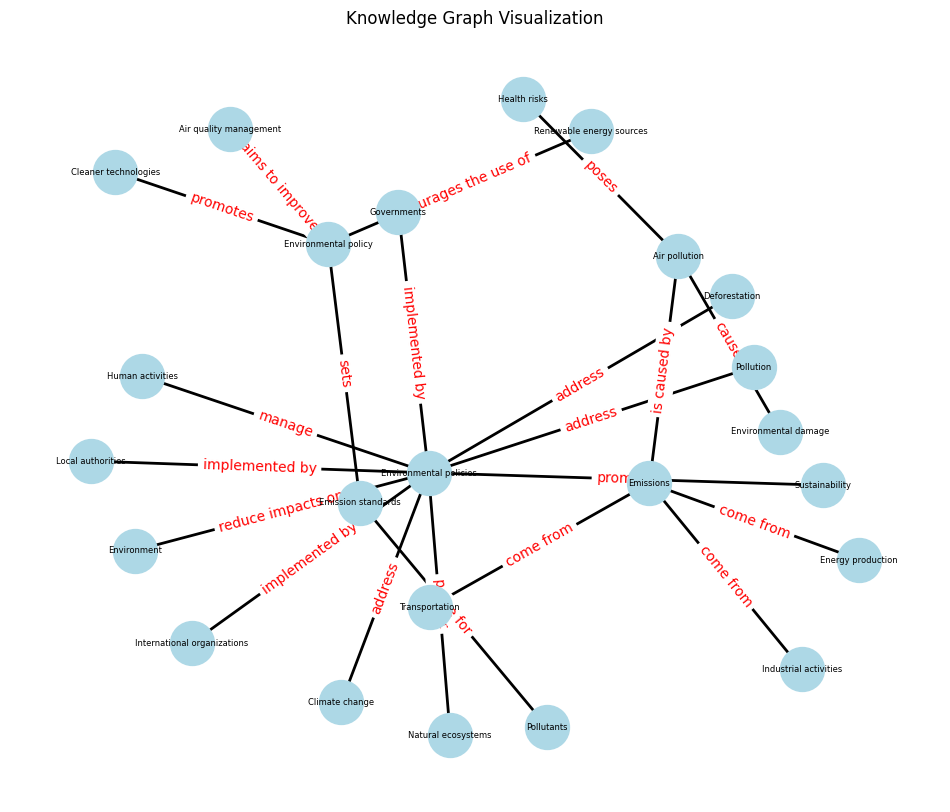


In [9]:
# 4. Element Summaries -> Graph Communities
def build_graph_from_summaries(summaries):
    G = nx.Graph()
    for summary in tqdm(summaries, desc="4. Element Summaries -> Graph Communities"):
        lines = summary.split("\n")
        entities_section = False
        relationships_section = False
        entities = []
        for line in lines:
            if line.startswith("Entities"):
                entities_section = True
                relationships_section = False
                continue
            elif line.startswith("Relationships"):
                entities_section = False
                relationships_section = True
                continue
            if entities_section and line.strip():
                if line[0].isdigit() and "." in line[1:4]:
                    line = line.split(".", 1)[1].strip()
                entity = line.strip()
                entities.append(entity)
                G.add_node(entity)
            elif relationships_section and line.strip():
                if line[0].isdigit() and "." in line[1:4]:
                    line = line.split(".", 1)[1].strip()
                if line.endswith("."):
                    line = line[:-1]
                parts = line.split("->")
                if len(parts) == 3:
                    source = parts[0].strip()
                    target = parts[-1].strip()
                    relation = parts[1].strip()
                    G.add_edge(source, target, label=relation)
                else:
                    print(f"Invalid relationship: {line}")
    return G


def visualize_graph(G):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))  # Increase the figure size if needed

    # Adjust node spacing by setting the 'k' parameter in spring_layout
    pos = nx.spring_layout(
        G, k=0.9
    )  # Increase 'k' to control the spacing between nodes (default is 0.1)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=1000)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2)

    # Draw the labels for the nodes
    nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")

    # Get edge labels from the graph and draw them
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    # Display the graph
    plt.title("Knowledge Graph Visualization")
    plt.axis("off")  # Hide the axis
    plt.show()


def detect_communities(graph):
    communities = []
    index = 0
    for component in tqdm(nx.connected_components(graph), desc="Detecting Communities"):
        subgraph = graph.subgraph(component)
        if len(subgraph.nodes) > 1:  # Leiden algorithm requires at least 2 nodes
            try:
                sub_communities = algorithms.leiden(subgraph)
                for community in sub_communities.communities:
                    communities.append(list(community))
            except Exception as e:
                # print(f"Error processing community {index}: {e}")
                communities.append(list(subgraph.nodes))
        else:
            communities.append(list(subgraph.nodes))
        index += 1
    return communities

#### 5. Graph Communities -> Community Summaries

community_summaries[0]:

The community of entities is centered around Environmental policies. They are designed to protect Natural ecosystems, promote Sustainability, and address various issues like Pollution, Deforestation, and Climate change. These policies are implemented by Governments, International organizations, and Local authorities. In addition, Environmental policies are used to manage Human activities and reduce the negative impacts these activities have on the Environment.


In [10]:
# 5. Graph Communities -> Community Summaries
def summarize_communities(communities, graph):
    community_summaries = []
    for community in tqdm(
        communities, desc="5. Graph Communities -> Community Summaries"
    ):
        subgraph = graph.subgraph(community)
        nodes = list(subgraph.nodes)
        edges = list(subgraph.edges(data=True))
        description = "Entities: " + ", ".join(nodes) + "\nRelationships: "
        relationships = []
        for edge in edges:
            relationships.append(f"{edge[0]} -> {edge[2]['label']} -> {edge[1]}")
        description += ", ".join(relationships)

        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {
                    "role": "system",
                    "content": "Summarize the following community of entities and relationships.",
                },
                {"role": "user", "content": description},
            ],
        )
        summary = response.choices[0].message.content.strip()
        community_summaries.append(summary)
    return community_summaries

#### 6. Community Summaries -> Community Answers -> Global Answer

In [11]:
# 6. Community Summaries -> Community Answers -> Global Answer
def generate_answers_from_communities(community_summaries, query):
    intermediate_answers = []
    for summary in tqdm(
        community_summaries,
        desc="6. Community Summaries -> Community Answers -> Global Answer",
    ):
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "Answer the following query based on the provided summary.",
                },
                {"role": "user", "content": f"Query: {query} Summary: {summary}"},
            ],
        )
        intermediate_answers.append(response.choices[0].message.content)

    final_response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "Combine these answers into a final, concise response.",
            },
            {
                "role": "user",
                "content": f"Intermediate answers: {intermediate_answers}",
            },
        ],
    )
    final_answer = final_response.choices[0].message.content
    return final_answer

In [12]:
# Putting all the process together
def graph_rag_pipeline(
    query: str, documents: List[str], chunk_size: int = 600, overlap_size: int = 100
):
    # 1. Source Documents -> Text Chunks
    chunks = split_documents_into_chunks(
        documents=documents, chunk_size=chunk_size, overlap_size=overlap_size
    )

    # 2. Text Chunks -> Element Instances
    instances = extract_instances_from_chunks(chunks=chunks)

    # 3. Element Instances → Element Summaries
    summaries = summarize_elements(instances=instances)

    # 4. Element Summaries -> Graph Communities
    graph = build_graph_from_summaries(summaries)
    visualize_graph(G=graph)
    communities = detect_communities(graph)

    # 5. Graph Communities -> Community Summaries
    community_summaries = summarize_communities(communities, graph)

    # 6. Community Summaries -> Community Answers -> Global Answer
    final_answer = generate_answers_from_communities(community_summaries, query)

    return final_answer

4. Element Summaries -> Graph Communities: 100%|██████████| 28/28 [00:00<00:00, 15819.03it/s]


Invalid relationship: Damage occurs especially during critical Growth stages
Invalid relationship: Advances in -> Solar technology -> make -> Solar panels more efficient and affordable


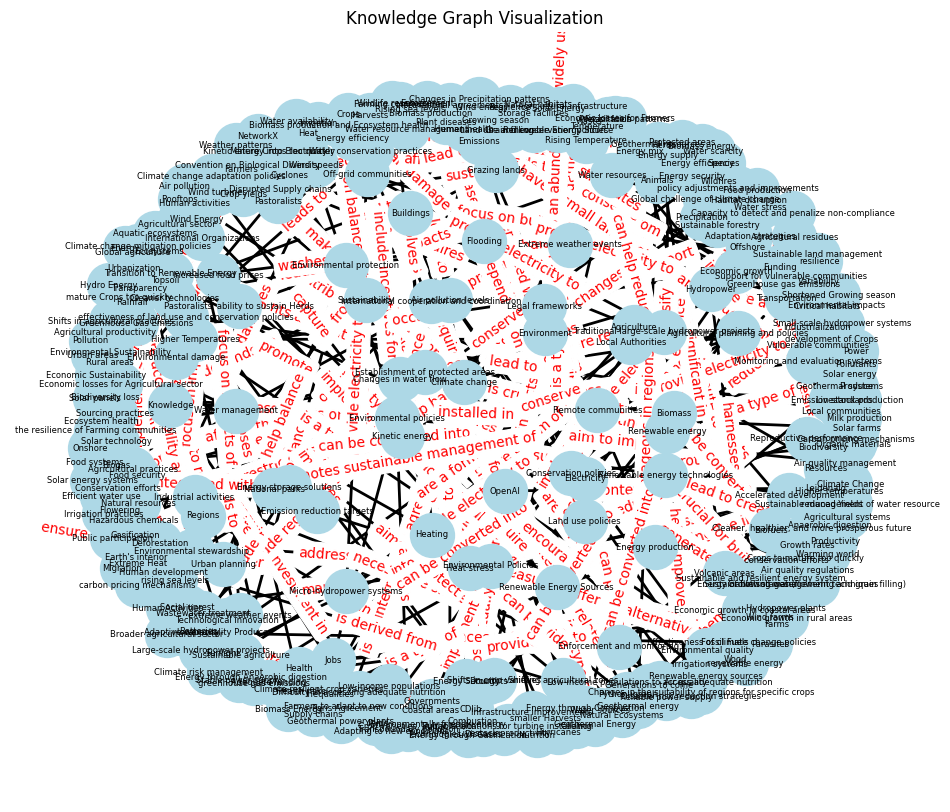

Detecting Communities: 78it [00:00, 5404.94it/s]
5. Graph Communities -> Community Summaries: 100%|██████████| 86/86 [04:55<00:00,  3.44s/it]
6. Community Summaries -> Community Answers -> Global Answer: 100%|██████████| 86/86 [02:56<00:00,  2.06s/it]


query: What are the main themes in these documents?
answer:
The main themes across the provided documents encompass a diverse range of topics including programming and artificial intelligence, environmental policies and technologies, climate change impacts and adaptation, agricultural productivity and water management, renewable energy and sustainability, socio-economic challenges, and legal operations. These themes highlight the interconnectedness of technology, environment, agriculture, energy, socio-economic factors, and legal frameworks:

1. **Technology and AI**: Focus on programming tools, algorithms, and network analysis relevant to AI applications.
   
2. **Environmental Policies and Sustainable Technologies**: Emphasis on creating and enforcing policies for environmental protection, cleaner technologies, and international cooperation.

3. **Climate Change**: Exploration of impacts such as sea level rise, agricultural shifts, and policy responses enhancing adaptation.

4. **Agr

In [13]:
query = "What are the main themes in these documents?"
answer = graph_rag_pipeline(query=query, documents=documents)
print("query:", query)
print("answer:")
print(answer)